Step 1: Loading Data
Dataset loaded with shape: (506, 14)

Step 2: Data Exploration
Dataset Shape:
Features: (506, 13)
Target: (506,)

Feature Statistics:
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  486.000000  486.000000  486.000000  486.000000  506.000000  506.000000   
mean     3.611874   11.211934   11.083992    0.069959    0.554695    6.284634   
std      8.720192   23.388876    6.835896    0.255340    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.081900    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.253715    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.560263   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  486.000000  506.000000  506

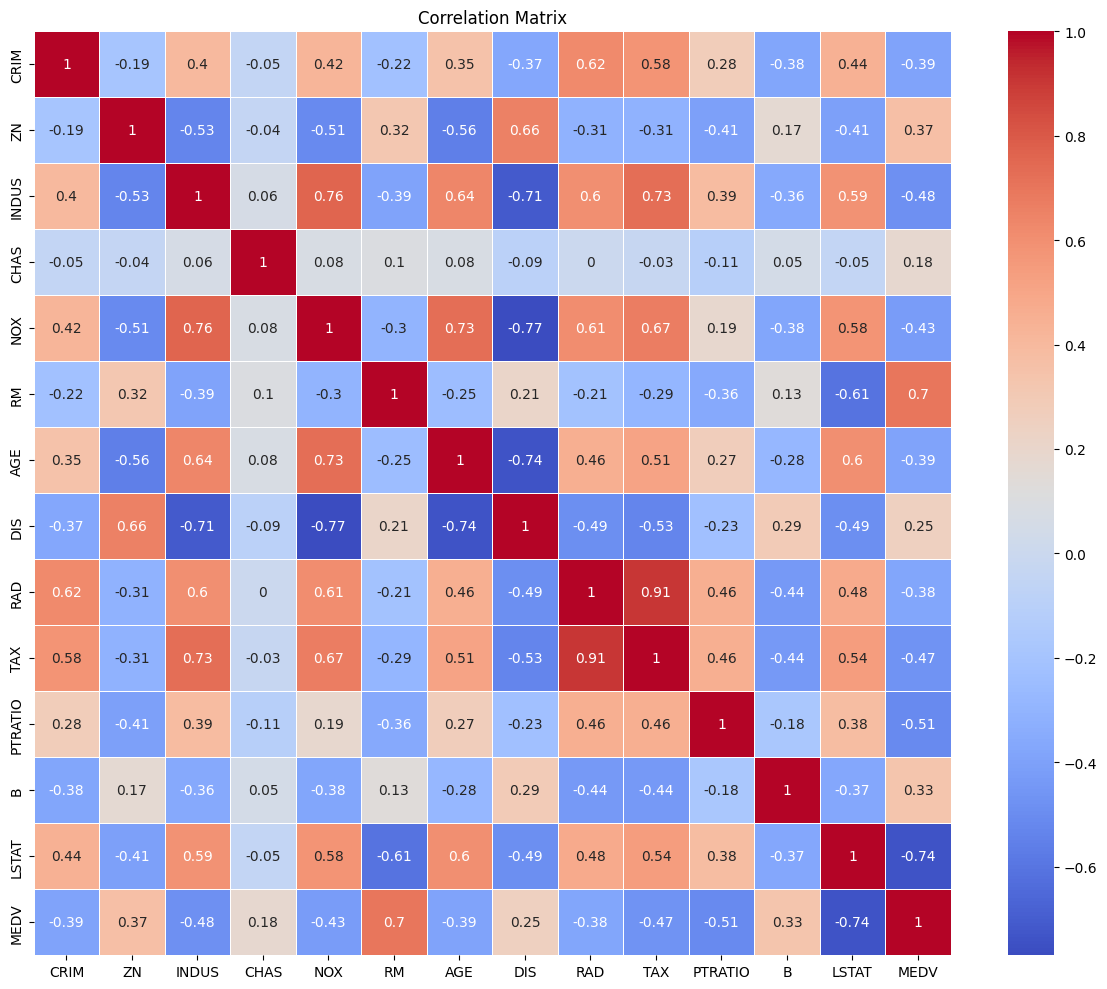

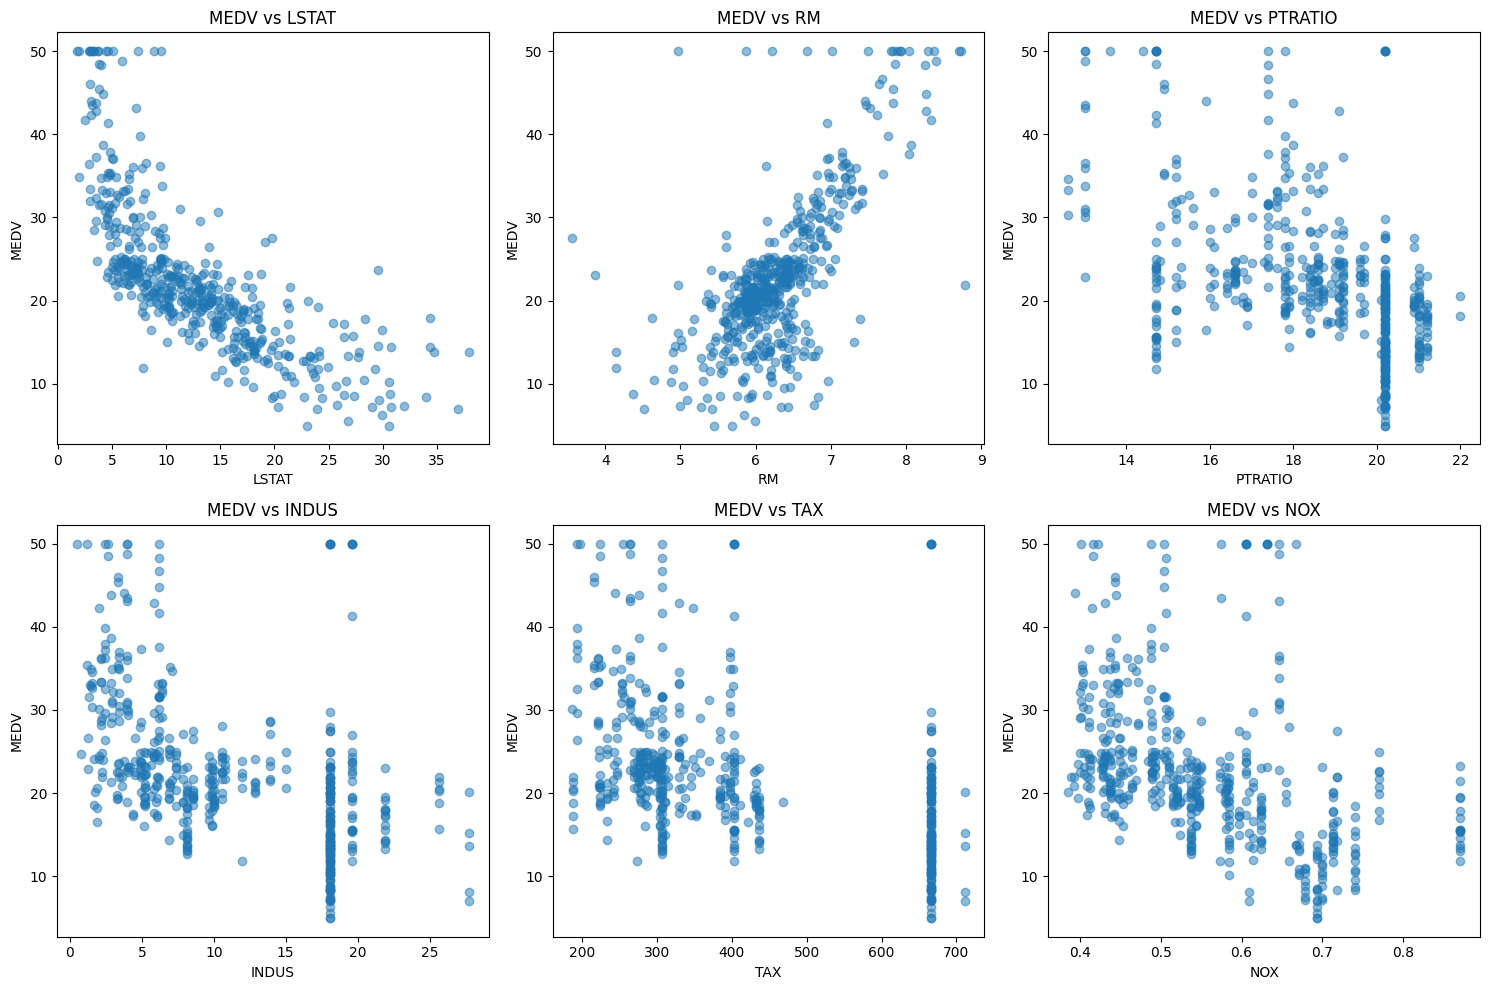

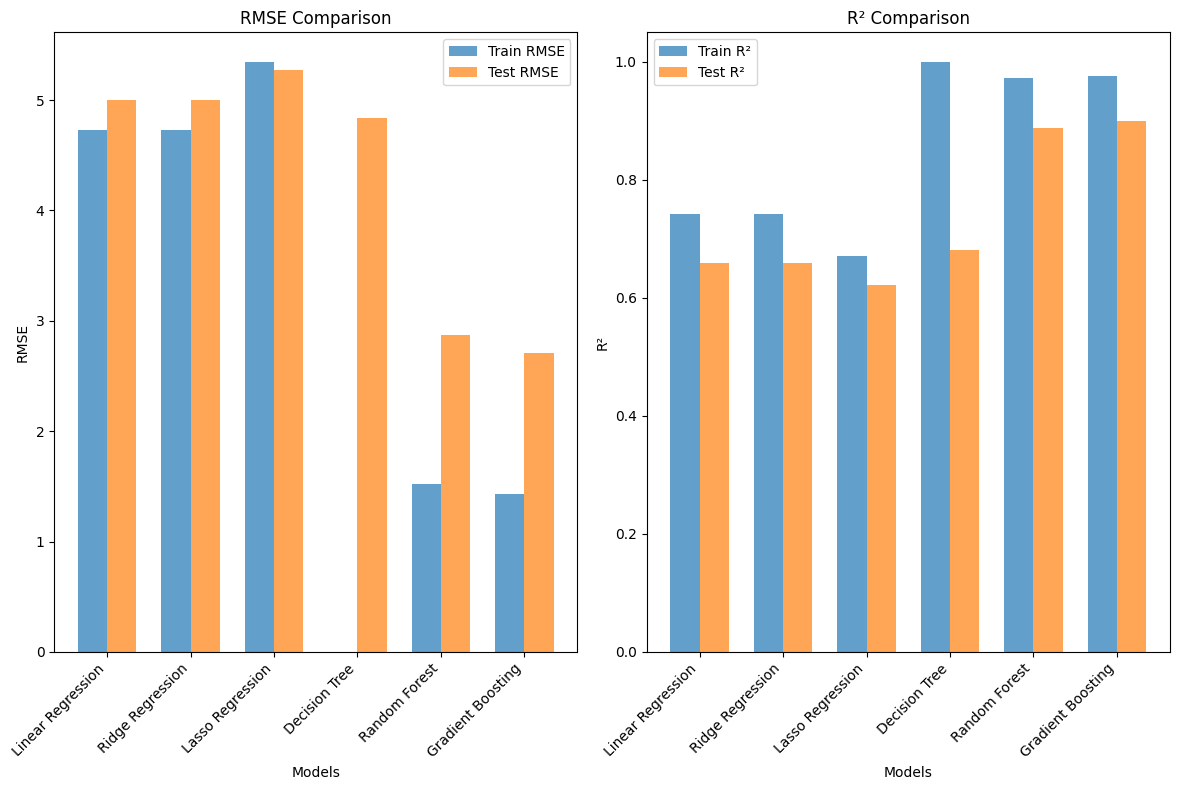

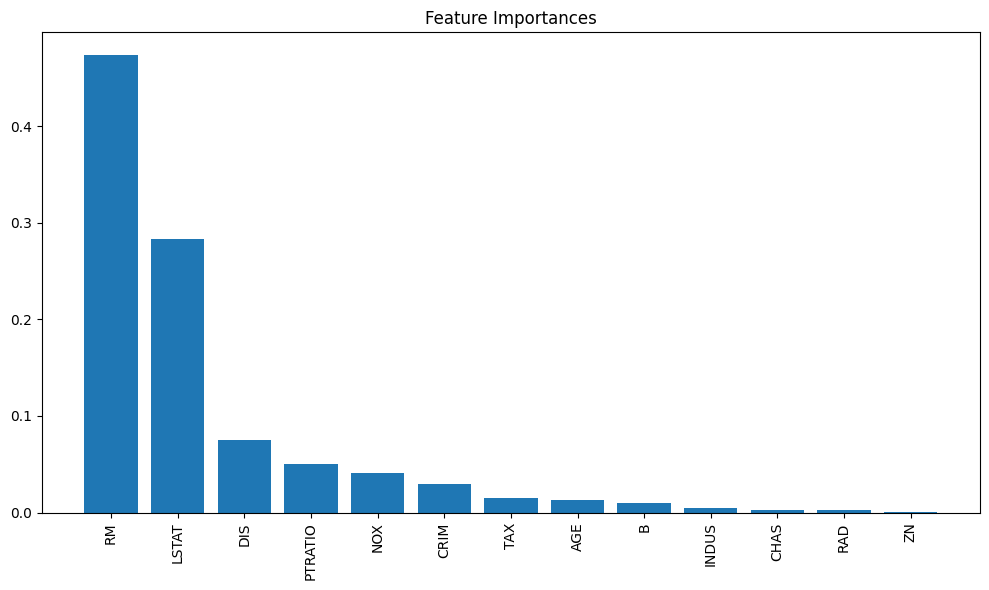

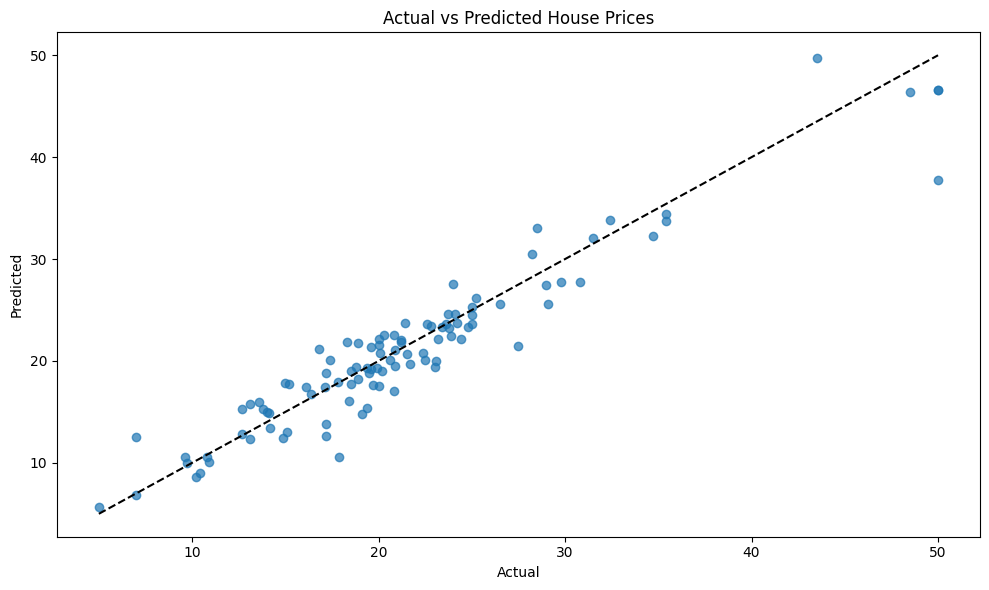

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load the dataset from the CSV file
def load_data(file_path="/content/HousingData.csv"):
    """Load the Boston Housing dataset from CSV file"""
    data = pd.read_csv(file_path)
    print(f"Dataset loaded with shape: {data.shape}")

    # Check if 'MEDV' is the target column (house prices)
    if 'MEDV' in data.columns:
        X = data.drop('MEDV', axis=1)
        y = data['MEDV']
    else:
        # If column names are different, assume the last column is the target
        X = data.iloc[:, :-1]
        y = data.iloc[:, -1]
        print("Assuming the last column is the target variable (house prices)")

    # Check for missing values
    if data.isnull().values.any():
        print("Warning: Dataset contains missing values. These will be handled in preprocessing.")

    return X, y

# Data Exploration
def explore_data(X, y):
    print("Dataset Shape:")
    print(f"Features: {X.shape}")
    print(f"Target: {y.shape}")

    print("\nFeature Statistics:")
    print(X.describe())

    print("\nChecking for missing values:")
    missing_values = X.isnull().sum()
    print(missing_values)

    # Creating a DataFrame that includes the target for correlation analysis
    full_data = X.copy()
    full_data['MEDV'] = y

    # Correlation matrix
    plt.figure(figsize=(12, 10))
    correlation_matrix = full_data.corr().round(2)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')

    # Relationship between important features and target
    plt.figure(figsize=(15, 10))
    # Select top 6 correlated features with the target
    correlations = correlation_matrix['MEDV'].abs().sort_values(ascending=False)
    important_features = correlations[1:7].index.tolist()  # Exclude MEDV itself

    for i, feature in enumerate(important_features):
        plt.subplot(2, 3, i+1)
        plt.scatter(X[feature], y, alpha=0.5)
        plt.title(f'MEDV vs {feature}')
        plt.xlabel(feature)
        plt.ylabel('MEDV')
    plt.tight_layout()
    plt.savefig('feature_relationships.png')

    return correlation_matrix

# Data Preprocessing
def preprocess_data(X, y, test_size=0.2, random_state=42):
    """
    Preprocess the data: handle missing values, outliers, and split into train/test sets
    """
    # Handle missing values
    if X.isnull().values.any():
        # For numerical columns, fill with median (more robust to outliers than mean)
        X = X.fillna(X.median())
        print("Missing values have been filled with median values")

    # Check for outliers using IQR method
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = ((X < lower_bound) | (X > upper_bound)).sum()
    print(f"Number of potential outliers in each feature:\n{outliers}")

    # For this exercise, we'll keep the outliers but note them
    # In a real scenario, you might consider removing or transforming them

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler

# Model Selection & Training
def train_models(X_train, y_train, X_train_scaled, random_state=42):
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(random_state=random_state),
        'Lasso Regression': Lasso(random_state=random_state),
        'Decision Tree': DecisionTreeRegressor(random_state=random_state),
        'Random Forest': RandomForestRegressor(random_state=random_state),
        'Gradient Boosting': GradientBoostingRegressor(random_state=random_state)
    }

    # Train each model and store them
    trained_models = {}
    for name, model in models.items():
        # For linear models, use scaled features
        if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
            model.fit(X_train_scaled, y_train)
            trained_models[name] = {'model': model, 'scaled': True}
        else:
            model.fit(X_train, y_train)
            trained_models[name] = {'model': model, 'scaled': False}

        print(f"Trained {name}")

    return trained_models

# Model Evaluation
def evaluate_models(trained_models, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled):
    results = {}

    for name, model_info in trained_models.items():
        model = model_info['model']
        use_scaled = model_info['scaled']

        # Use appropriate features (scaled or not)
        X_tr = X_train_scaled if use_scaled else X_train
        X_te = X_test_scaled if use_scaled else X_test

        # Make predictions
        y_train_pred = model.predict(X_tr)
        y_test_pred = model.predict(X_te)

        # Calculate metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        results[name] = {
            'Train MSE': train_mse,
            'Test MSE': test_mse,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Train MAE': train_mae,
            'Test MAE': test_mae
        }

    # Create a results DataFrame
    results_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Train RMSE': [results[model]['Train RMSE'] for model in results],
        'Test RMSE': [results[model]['Test RMSE'] for model in results],
        'Train R²': [results[model]['Train R²'] for model in results],
        'Test R²': [results[model]['Test R²'] for model in results]
    })

    # Sort by Test RMSE
    results_df = results_df.sort_values('Test RMSE')

    print("\nModel Performance Comparison:")
    print(results_df)

    # Visualize Results
    plt.figure(figsize=(12, 8))

    # RMSE Comparison
    plt.subplot(1, 2, 1)
    bar_width = 0.35
    index = np.arange(len(results))
    plt.bar(index, [results[model]['Train RMSE'] for model in results], bar_width,
            label='Train RMSE', alpha=0.7)
    plt.bar(index + bar_width, [results[model]['Test RMSE'] for model in results], bar_width,
            label='Test RMSE', alpha=0.7)
    plt.xlabel('Models')
    plt.ylabel('RMSE')
    plt.title('RMSE Comparison')
    plt.xticks(index + bar_width/2, list(results.keys()), rotation=45, ha='right')
    plt.legend()

    # R² Comparison
    plt.subplot(1, 2, 2)
    plt.bar(index, [results[model]['Train R²'] for model in results], bar_width,
            label='Train R²', alpha=0.7)
    plt.bar(index + bar_width, [results[model]['Test R²'] for model in results], bar_width,
            label='Test R²', alpha=0.7)
    plt.xlabel('Models')
    plt.ylabel('R²')
    plt.title('R² Comparison')
    plt.xticks(index + bar_width/2, list(results.keys()), rotation=45, ha='right')
    plt.legend()

    plt.tight_layout()
    plt.savefig('model_comparison.png')

    return results, results_df

# Fine-tune the best model
def fine_tune_model(X_train, y_train, X_train_scaled, results_df, random_state=42):
    # Identify the best model based on Test RMSE
    best_model_name = results_df.iloc[0]['Model']
    print(f"\nFine-tuning {best_model_name}...")

    if best_model_name == 'Linear Regression':
        # Linear Regression doesn't have hyperparameters to tune
        return LinearRegression(), True

    elif best_model_name == 'Ridge Regression':
        param_grid = {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
        model = Ridge(random_state=random_state)
        use_scaled = True

    elif best_model_name == 'Lasso Regression':
        param_grid = {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
        }
        model = Lasso(random_state=random_state)
        use_scaled = True

    elif best_model_name == 'Decision Tree':
        param_grid = {
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        model = DecisionTreeRegressor(random_state=random_state)
        use_scaled = False

    elif best_model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        model = RandomForestRegressor(random_state=random_state)
        use_scaled = False

    else:  # Gradient Boosting
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
        model = GradientBoostingRegressor(random_state=random_state)
        use_scaled = False

    # Use the appropriate feature set
    X_features = X_train_scaled if use_scaled else X_train

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_features, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {-grid_search.best_score_}")

    return grid_search.best_estimator_, use_scaled

# Feature Importance Analysis
def analyze_feature_importance(model, feature_names):
    # Check if the model has feature_importances_ attribute
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances')
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig('feature_importance.png')

        # Print feature importance
        print("\nFeature Importance:")
        for i in indices:
            print(f"{feature_names[i]}: {importances[i]:.4f}")

    # For linear models
    elif hasattr(model, 'coef_'):
        coefs = model.coef_
        indices = np.argsort(np.abs(coefs))[::-1]

        plt.figure(figsize=(10, 6))
        plt.title('Feature Coefficients')
        plt.bar(range(len(coefs)), coefs[indices], align='center')
        plt.xticks(range(len(coefs)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig('feature_coefficients.png')

        # Print coefficients
        print("\nFeature Coefficients:")
        for i in indices:
            print(f"{feature_names[i]}: {coefs[i]:.4f}")

# Main function to run everything
def main():
    # Load the data
    print("Step 1: Loading Data")
    X, y = load_data()

    # Data Exploration
    print("\nStep 2: Data Exploration")
    correlation_matrix = explore_data(X, y)

    # Data Preprocessing
    print("\nStep 3: Data Preprocessing")
    X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler = preprocess_data(X, y)

    # Model Training
    print("\nStep 4: Model Training")
    trained_models = train_models(X_train, y_train, X_train_scaled)

    # Model Evaluation
    print("\nStep 5: Model Evaluation")
    results, results_df = evaluate_models(trained_models, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

    # Fine-tune Best Model
    print("\nStep 6: Fine-tuning")
    best_model, use_scaled = fine_tune_model(X_train, y_train, X_train_scaled, results_df)

    # Evaluate Tuned Model
    print("\nStep 7: Evaluating Fine-tuned Model")
    X_tr = X_train_scaled if use_scaled else X_train
    X_te = X_test_scaled if use_scaled else X_test

    y_train_pred = best_model.predict(X_tr)
    y_test_pred = best_model.predict(X_te)

    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    # Feature Importance Analysis
    print("\nStep 8: Feature Importance Analysis")
    analyze_feature_importance(best_model, X.columns)

    # Visualize Actual vs Predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted House Prices')
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png')

    # Save the model
    from joblib import dump
    dump(best_model, 'best_model.joblib')
    dump(scaler, 'scaler.joblib')

    print("\nModel saved as 'best_model.joblib'")
    print("Scaler saved as 'scaler.joblib'")

    return best_model, scaler

# Function to make predictions with the trained model
def predict_house_price(features, model, scaler=None, use_scaled=True):
    """
    Make predictions using the trained model

    Parameters:
    -----------
    features : array-like
        Features for which to predict the house price
    model : trained model
        The trained regression model
    scaler : StandardScaler, optional
        Scaler used for preprocessing
    use_scaled : bool
        Whether to use scaled features for prediction

    Returns:
    --------
    float
        Predicted house price
    """
    # Convert to DataFrame if not already
    if not isinstance(features, pd.DataFrame):
        if isinstance(features, list):
            features = pd.DataFrame([features], columns=X.columns)
        else:
            features = pd.DataFrame(features).T
            features.columns = X.columns

    # Scale features if required
    if use_scaled and scaler is not None:
        features = scaler.transform(features)

    # Make prediction
    prediction = model.predict(features)

    return prediction[0]

# Run the analysis
if __name__ == "__main__":
    best_model, scaler = main()

    # Load a sample from the test set to demonstrate prediction
    X, y = load_data()
    sample_house = X.iloc[0]
    actual_price = y.iloc[0]

    # Make a prediction
    predicted_price = predict_house_price(sample_house, best_model, scaler)
    print(f"\nExample Prediction:")
    print(f"Actual price: ${actual_price:.2f}k")
    print(f"Predicted price: ${predicted_price:.2f}k")
    print(f"Difference: ${abs(actual_price - predicted_price):.2f}k")